In [81]:

import numpy as np
import pandas as pd
import tensorflow as tf

import datetime 
import statsmodels as sm

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dropout


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [82]:
df = pd.read_csv('SP500.csv')
n_stocks_show = 15
print('Dataset shape', df.shape)
# df.iloc[:, :n_stocks_show].head()
df.head()

Dataset shape (3014, 7)


,Date,Open,High,Low,Close,Price,Volume
0,2022-12-21,3839.49,3889.82,3839.49,3878.44,3878.44,3775200000
1,2022-12-20,3810.47,3838.24,3795.62,3821.62,3821.62,3985370000
2,2022-12-19,3853.79,3854.86,3800.04,3817.66,3817.66,3969610000
3,2022-12-16,3890.91,3890.91,3827.91,3852.36,3852.36,7493660000
4,2022-12-15,3958.37,3958.37,3879.45,3895.75,3895.75,4493900000


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014 entries, 0 to 3013
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3014 non-null   object 
 1   Open    3014 non-null   float64
 2   High    3014 non-null   float64
 3   Low     3014 non-null   float64
 4   Close   3014 non-null   float64
 5   Price   3014 non-null   float64
 6   Volume  3014 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 165.0+ KB


In [84]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [85]:
df.dropna(inplace=True)
df.set_index('Date',inplace=True)
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Price     float64
Volume      int64
dtype: object

In [86]:
def check_for_nulls(df):
    """
    Test and report number of NAs in each column of the input data frame
    :param df: pandas.DataFrame
    :return: None
    """
    for col in df.columns.values:
        num_nans = np.sum(df[col].isnull())
        if num_nans > 0:
            print('%d Nans in col %s' % (num_nans, col))
    print('New shape of df: ', df.shape)

In [87]:
df_sample = df[(df.index > datetime.date(2011,1,1))]
check_for_nulls(df_sample)

New shape of df:  (3014, 6)


#EDA</br>

Average market Cap : 7547422.020000
Average market Volume : 11706526870000.000000


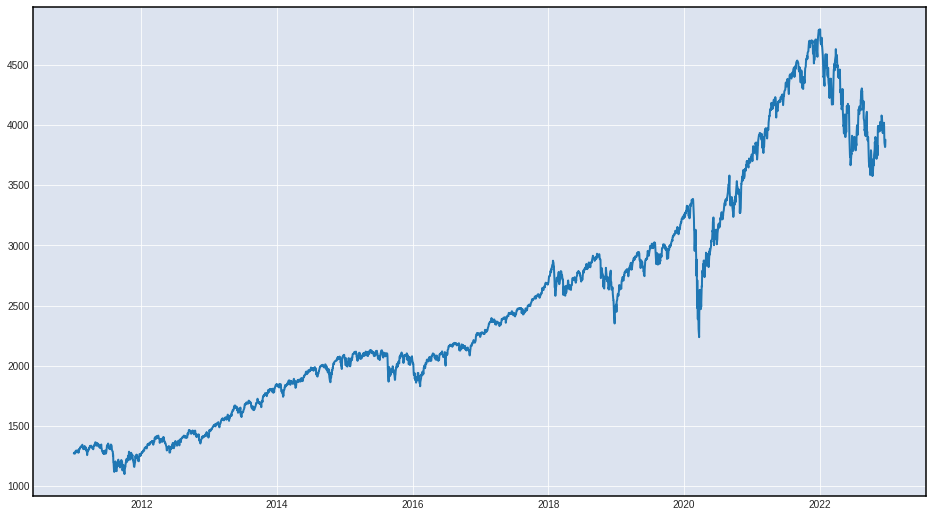

In [89]:
average_market_cap = df.Price.sum().mean()
average_market_volume = df.Volume.sum().mean()
print("Average market Cap : %f" %(average_market_cap))
print("Average market Volume : %f" %(average_market_volume))


fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(df_sample.Price, label='S&P500', color='tab:blue')
# df_sample['VWAP'] = df_sample.V_Price.rolling(window=20).mean()/df_sample['Volume'].rolling(window=20).mean()
# ax.plot(df_sample.VWAP, label='VWAP', color='tab:grey')



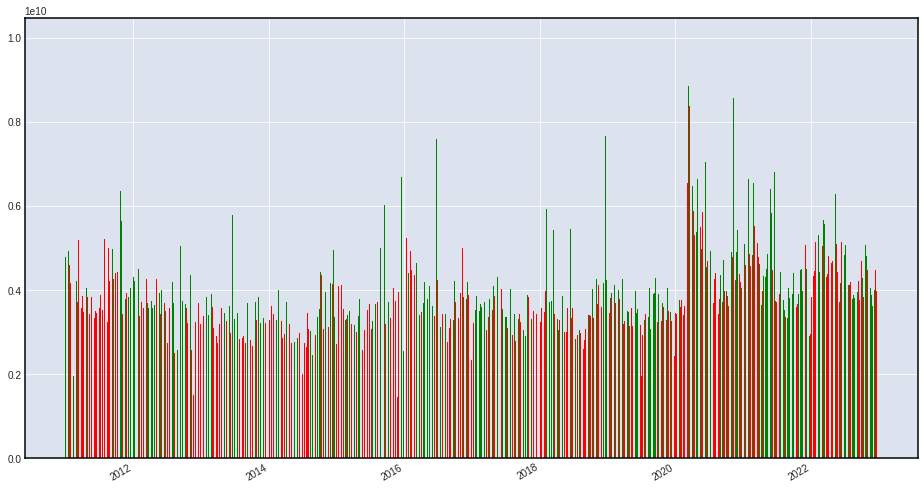

In [90]:
fig, ax = plt.subplots(figsize=(16, 9))
# Plot all bars with green facecolor 
bars = ax.bar(np.array(df_sample.index),df_sample.Volume,facecolor='g')
# Loop over bars
for i, bar in enumerate(bars):
    if i == 0: 
        continue

    # Find bar heights
    h = bar.get_height()
    h0 = bars[i-1].get_height()

    # Change bar color to red if height less than previous bar
    if h < h0: bar.set_facecolor('r')
fig.autofmt_xdate()

#Calculating VWAP

In [91]:
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Date
2022-12-21          NaN
2022-12-20    24.673563
2022-12-19   -12.443166
2022-12-16   -37.711979
2022-12-15   -47.573369
                ...    
2011-01-07    -2.093700
2011-01-06    -2.677852
2011-01-05     2.627893
2011-01-04     2.497654
2011-01-03     5.272973
Name: VWAP, Length: 3014, dtype: float64


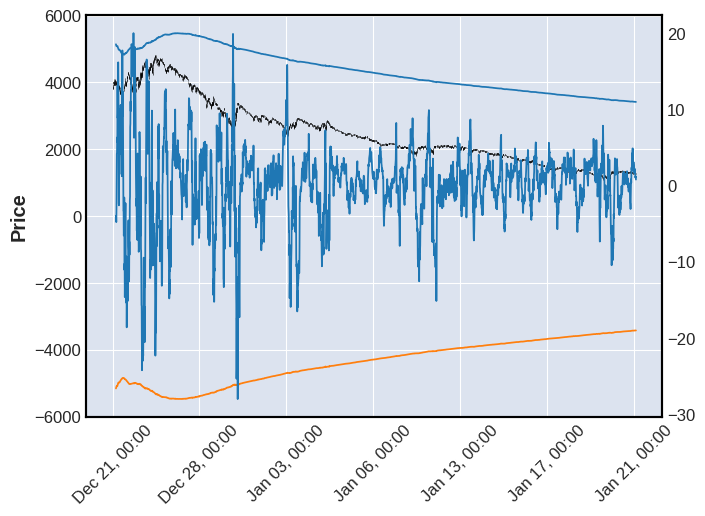

In [92]:
from pandas.core import window
import mplfinance as mpf
import math

df_sample['V_Price'] = (df_sample['Price']-df_sample['Open'])*df_sample['Volume']
df_sample['VWAP'] = df_sample.V_Price.rolling(window=2).mean()/df_sample['Volume'].rolling(window=2).mean()

print(df_sample['VWAP'])
# df_sample.set_index('Date',inplace=True)

# df_sample.set_index(['Date'], inplace=True)
df_sample.index = pd.to_datetime(df.index)
df_sample.index.name = 'Date'


# fig, ax = plt.subplots(figsize=(16, 9))

df_sample['VWAP'] = df_sample.V_Price.rolling(window=20).mean()/df_sample['Volume'].rolling(window=20).mean()
df_sample['VWAP_MEAN_DIFF'] = ((df_sample.High + df_sample.Low) / 2) - df_sample.VWAP
df_sample['SQ_DIFF'] = df_sample.VWAP_MEAN_DIFF.apply(lambda x: math.pow(x, 2))
df_sample['SQ_DIFF_MEAN'] = df_sample.SQ_DIFF.expanding().mean()
df_sample['STDEV_TT'] = df_sample.SQ_DIFF_MEAN.apply(math.sqrt)

stdev_multiple_1 = 1.28
stdev_multiple_2 = 2.01
stdev_multiple_3 = 2.51

df_sample['STDEV_1'] = df_sample.VWAP + stdev_multiple_1 * df_sample['STDEV_TT']
df_sample['STDEV_N1'] = df_sample.VWAP - stdev_multiple_1 * df_sample['STDEV_TT']

addplot  = [
    mpf.make_addplot(df_sample['VWAP']),
    mpf.make_addplot(df_sample['STDEV_1']),
    mpf.make_addplot(df_sample['STDEV_N1']),
]

mpf.plot(df_sample, type='candle', addplot=addplot)

# ax.plot(df_sample.VWAP, label='VWAP', color='tab:grey')

### Calculate price log-returns

In [93]:
asset_returns = np.log(df) - np.log(df.shift(1))
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,Open,High,Low,Close,Price,Volume
Date,,,,,,
2022-12-20,-0.007587,-0.013349,-0.011492,-0.014759,-0.014759,0.054177
2022-12-19,0.011305,0.004321,0.001164,-0.001037,-0.001037,-0.003962
2022-12-16,0.009586,0.009308,0.007307,0.009048,0.009048,0.635389
2022-12-15,0.017189,0.017189,0.013374,0.011200,0.011200,-0.511336
2022-12-14,0.014340,0.023813,0.021976,0.025237,0.025237,-0.004809


In [94]:
from sklearn.preprocessing import StandardScaler

log_ret_mat_std = StandardScaler().fit_transform(asset_returns.values)
log_ret_df_std = pd.DataFrame(data=log_ret_mat_std, 
                              index=asset_returns.index,
                              columns=asset_returns.columns.values) 
log_ret_df_std.iloc[:, :10].head()

,Open,High,Low,Close,Price,Volume
Date,,,,,,
2022-12-20,-0.729124,-1.528954,-1.125302,-1.279335,-1.279335,0.301689
2022-12-19,1.179578,0.552567,0.155242,-0.059279,-0.059279,-0.022317
2022-12-16,1.005944,1.140116,0.776871,0.837415,0.837415,3.540758
2022-12-15,1.774140,2.068497,1.390760,1.028756,1.028756,-2.849886
2022-12-14,1.486216,2.848727,2.261140,2.276850,2.276850,-0.027036


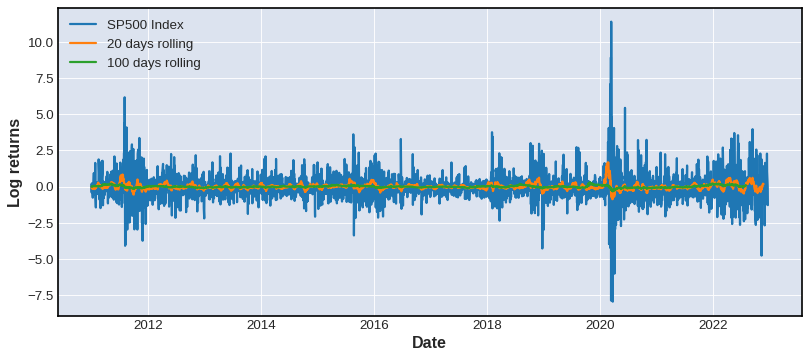

In [95]:
spx_index = df.loc[:, 'Price']
# Calculate the 20 and 100 days moving averages of the log-returns
short_rolling_spx = log_ret_df_std[['Price']].rolling(window=20).mean()
long_rolling_spx = log_ret_df_std[['Price']].rolling(window=100).mean()

# Plot the index and rolling averages
fig=plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.plot(log_ret_df_std.index, log_ret_df_std[['Price']], label='SP500 Index')
ax.plot(short_rolling_spx.index, short_rolling_spx, label='20 days rolling')
ax.plot(long_rolling_spx.index, long_rolling_spx, label='100 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')
ax.legend(loc=2)
plt.show()

In [96]:
roll_avg_20 = df_sample.Price.rolling(window=20).mean()
roll_avg_50 = df_sample.Price.rolling(window=50).mean()
roll_avg_100 = df_sample.Price.rolling(window=100).mean()
roll_avg_200 = df_sample.Price.rolling(window=200).mean()

In [97]:
ewm_avg_20 = df_sample.Price.ewm(span=20).mean()
ewm_avg_50 = df_sample.Price.ewm(span=50).mean()
ewm_avg_100 = df_sample.Price.ewm(span=100).mean()
ewm_avg_200 = df_sample.Price.ewm(span=200).mean()

[Text(0, 0.5, 'S&P 500'), Text(0.5, 0, 'Date')]

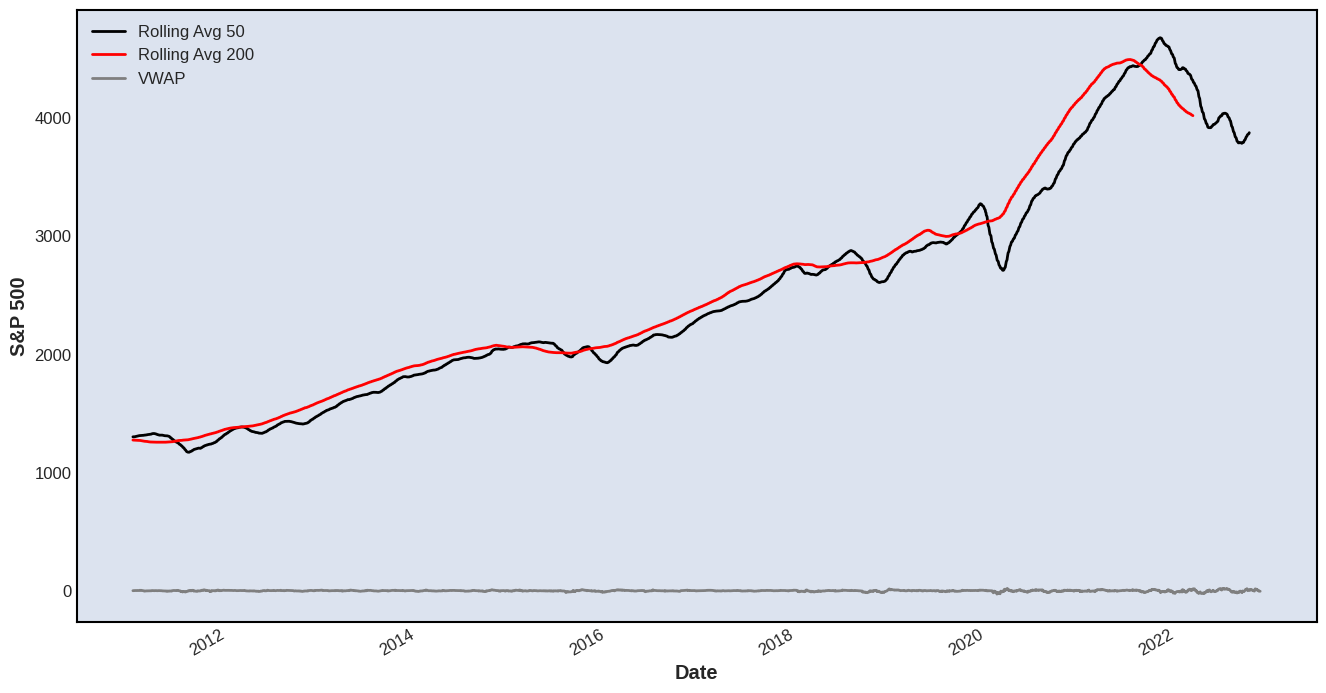

In [101]:
fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()
# ax.plot(ewm_avg_20, label='Rolling Avg 20', color='g')
ax.plot(roll_avg_50, label='Rolling Avg 50', color='k')
ax.plot(roll_avg_200, label='Rolling Avg 200', color='r')
ax.plot(df_sample.VWAP, label='VWAP', color='tab:grey')
ax.legend()
ax.grid()
ax.set(xlabel='Date',ylabel='S&P 500')


[Text(0, 0.5, 'S&P 500'), Text(0.5, 0, 'Date')]

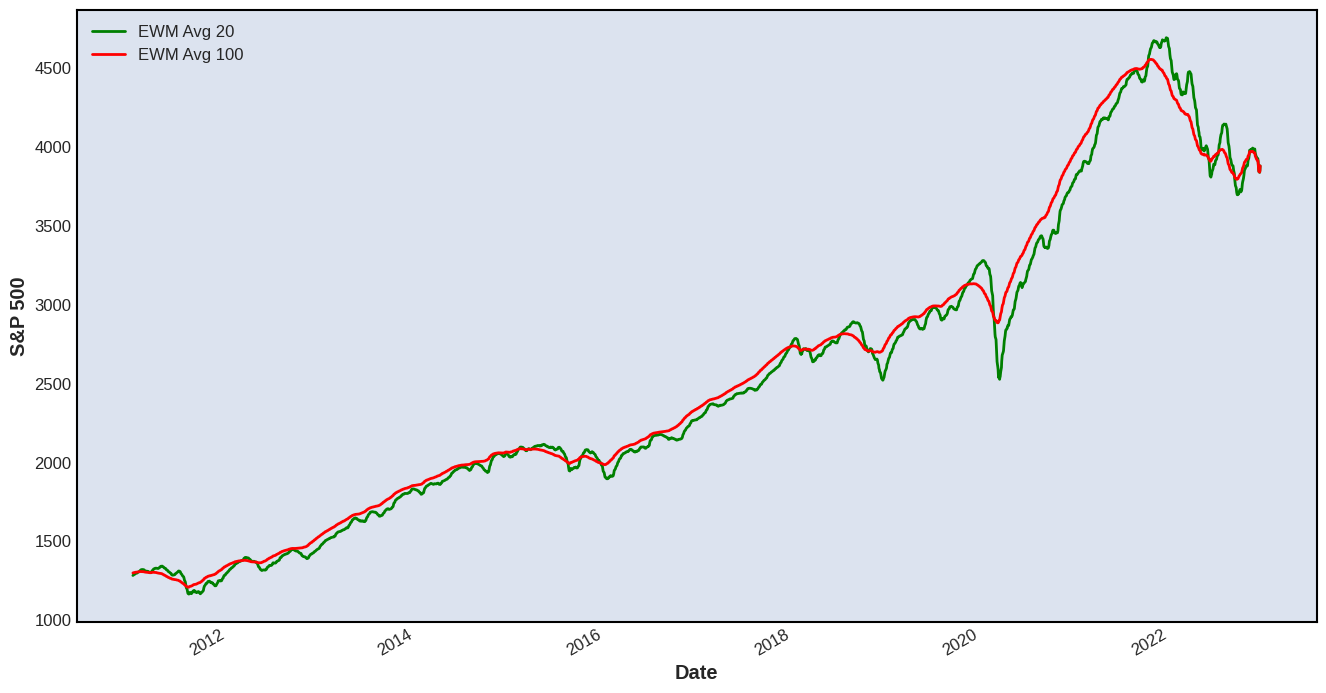

In [100]:
fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()
ax.plot(ewm_avg_20, label='EWM Avg 20', color='g')
# ax.plot(roll_avg_50, label='Rolling Avg 50', color='k')
ax.plot(ewm_avg_100, label='EWM Avg 100', color='r')
ax.legend()
ax.grid()
ax.set(xlabel='Date',ylabel='S&P 500')

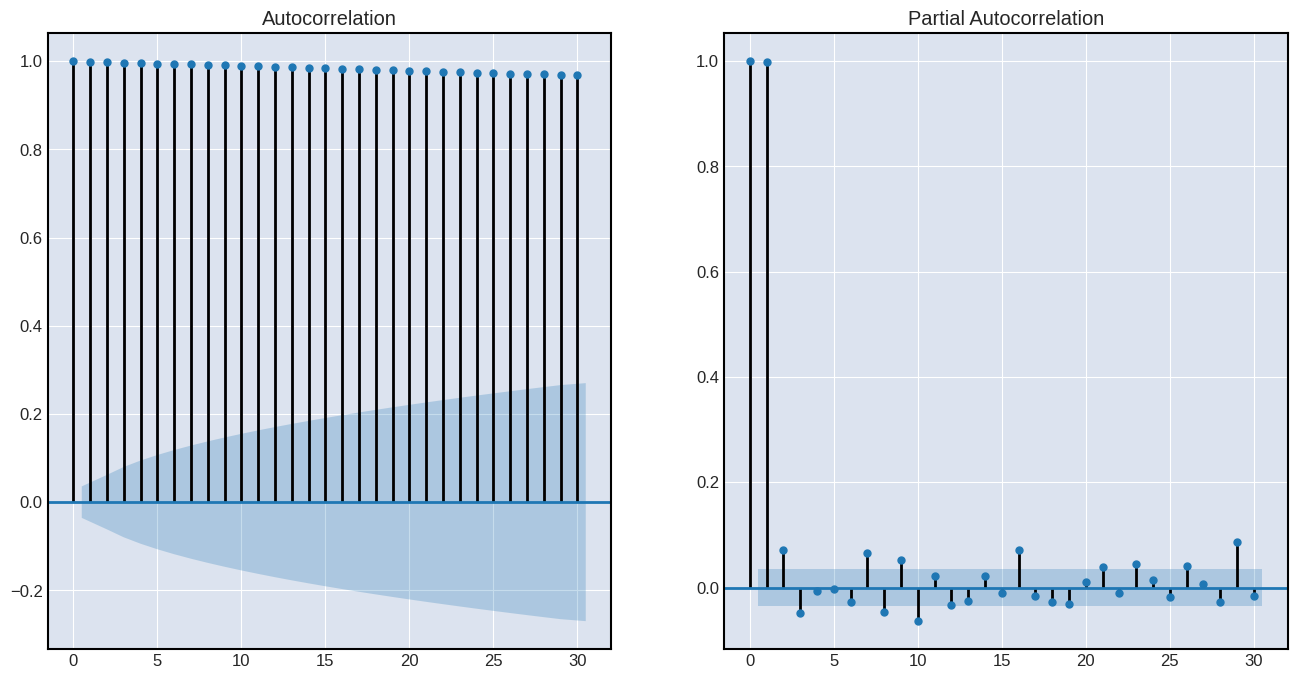

In [103]:
import statsmodels.api as sm

# Graph data
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig = sm.graphics.tsa.plot_acf(df_sample.iloc[1:]['Price'], lags=30, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df_sample.iloc[1:]['Price'], lags=30, ax=axes[1])

In [104]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [106]:
check_stationarity(df_sample.Price)

The test statistic: -0.996453
p-value: 0.754556
Critical Values:
1%: -3.433
5%: -2.863
10%: -2.567


In [107]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

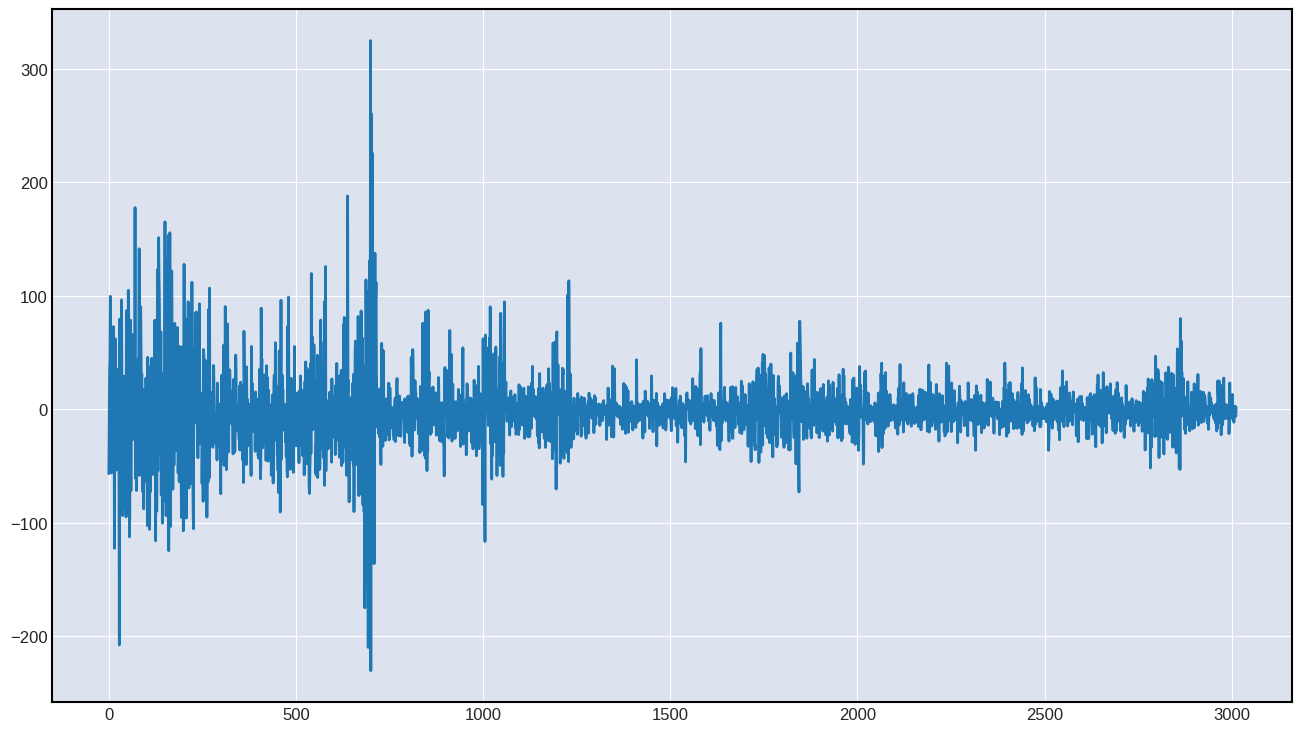

In [109]:
df_diff =  difference(df_sample.Price, 1)
     

df_diff.plot(figsize=(16, 9))

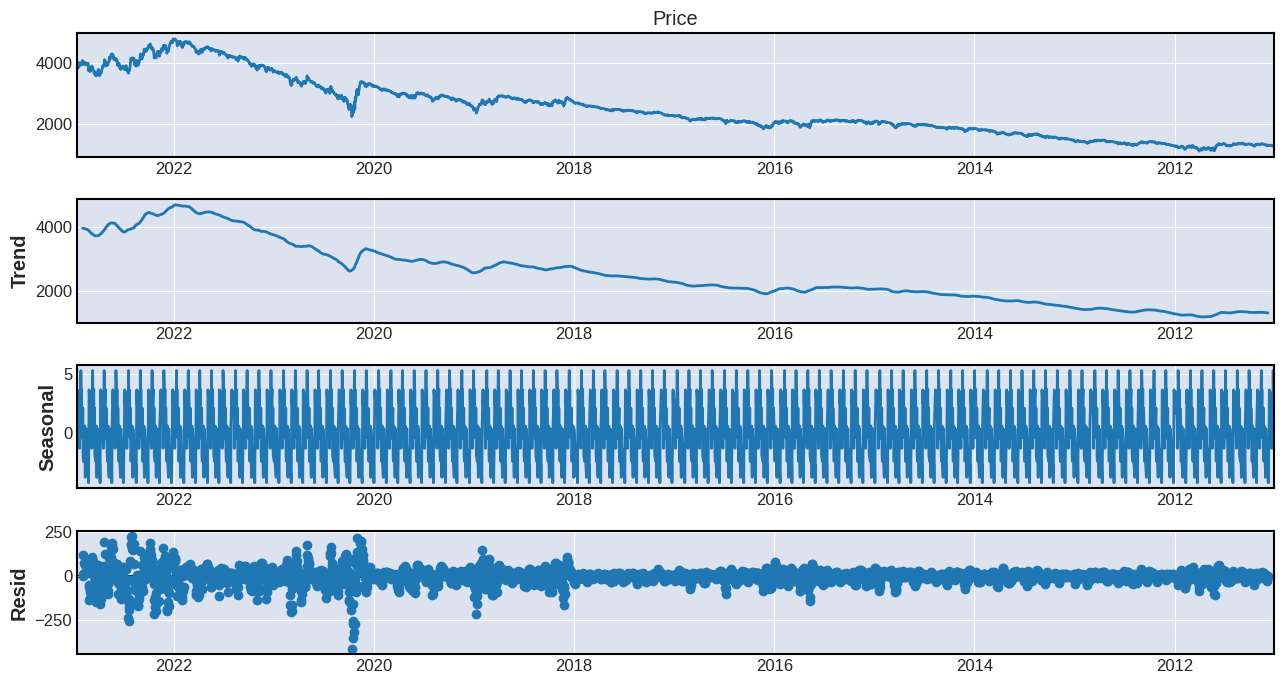

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_sample['Price'], model='additive', freq=30)
plt.rcParams["figure.figsize"] = [13, 7]
fig = decomposition.plot()

In [112]:
# move to top 
df_sample = df_sample.assign(y_log=np.log(df_sample.Price))
df_sample.head()

,Open,High,Low,Close,Price,Volume,V_Price,VWAP,VWAP_MEAN_DIFF,SQ_DIFF,SQ_DIFF_MEAN,STDEV_TT,STDEV_1,STDEV_N1,y_log
Date,,,,,,,,,,,,,,,
2022-12-21,3839.49,3889.82,3839.49,3878.44,3878.44,3775200000,1.470440e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.263188
2022-12-20,3810.47,3838.24,3795.62,3821.62,3821.62,3985370000,4.443688e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.248430
2022-12-19,3853.79,3854.86,3800.04,3817.66,3817.66,3969610000,-1.434220e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.247393
2022-12-16,3890.91,3890.91,3827.91,3852.36,3852.36,7493660000,-2.888806e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.256441
2022-12-15,3958.37,3958.37,3879.45,3895.75,3895.75,4493900000,-2.814080e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.267641


#Long Short-Term Memory

In [114]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [115]:
scaled_df = df_sample.Price.values.reshape(df_sample.Price.shape[0], 1)
scaled_df = scaler.fit_transform(scaled_df)
scaled_df.shape

(3014, 1)

In [116]:
log_ret_mat_std = StandardScaler().fit_transform(asset_returns.values)
log_ret_df_std = pd.DataFrame(data=log_ret_mat_std, 
                              index=asset_returns.index,
                              columns=asset_returns.columns.values) 
log_ret_df_std.iloc[:, :10].head()

,Open,High,Low,Close,Price,Volume
Date,,,,,,
2022-12-20,-0.729124,-1.528954,-1.125302,-1.279335,-1.279335,0.301689
2022-12-19,1.179578,0.552567,0.155242,-0.059279,-0.059279,-0.022317
2022-12-16,1.005944,1.140116,0.776871,0.837415,0.837415,3.540758
2022-12-15,1.774140,2.068497,1.390760,1.028756,1.028756,-2.849886
2022-12-14,1.486216,2.848727,2.261140,2.276850,2.276850,-0.027036


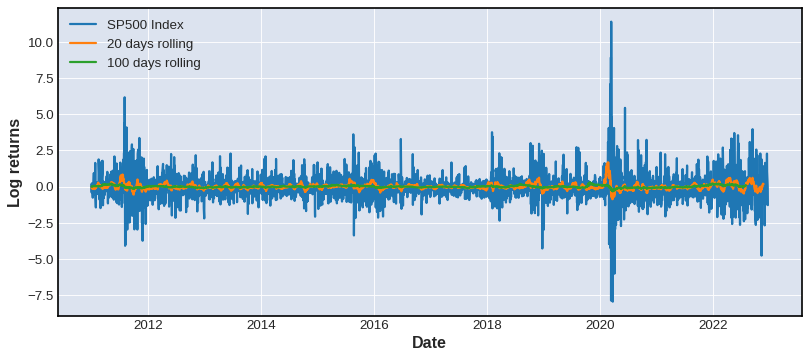

In [118]:
spx_index = df.loc[:, 'Price']
# Calculate the 20 and 100 days moving averages of the log-returns
short_rolling_spx = log_ret_df_std[['Price']].rolling(window=20).mean()
long_rolling_spx = log_ret_df_std[['Price']].rolling(window=100).mean()

# Plot the index and rolling averages
fig=plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.plot(log_ret_df_std.index, log_ret_df_std[['Price']], label='SP500 Index')
ax.plot(short_rolling_spx.index, short_rolling_spx, label='20 days rolling')
ax.plot(long_rolling_spx.index, long_rolling_spx, label='100 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')
ax.legend(loc=2)
plt.show()

In [120]:
def preprocess(df, look_back):
    X, y = [], []
    for i in range(look_back, len(df)):
        X.append(df[i-look_back:i,0])
        y.append(df[i,0])
    return np.array(X),np.array(y)

In [121]:
look_back = 60
X, y = preprocess(scaled_df, look_back)

In [122]:
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

2363
591
2363
591


In [123]:
import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import BatchNormalization

In [124]:
#Build the model
model1 = Sequential()
model1.add(LSTM(64, input_shape=(X_train.shape[1],1)))

model1.add(Dense(1))
model1.compile(optimizer='adagrad',loss='mse',metrics='accuracy')

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [125]:
# Fit model with history to check for overfitting

history1 = model1.fit(X_train,y_train,epochs=100, validation_data=(X_test,y_test),shuffle=False, batch_size=20)

Epoch 1/100
119/119 [==============================] - 8s 10ms/step - loss: 0.0959 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0017
Epoch 2/100
119/119 [==============================] - 1s 5ms/step - loss: 0.0276 - accuracy: 4.2319e-04 - val_loss: 0.0168 - val_accuracy: 0.0017
Epoch 3/100
119/119 [==============================] - 1s 5ms/step - loss: 0.0141 - accuracy: 4.2319e-04 - val_loss: 0.0193 - val_accuracy: 0.0017
Epoch 4/100
119/119 [==============================] - 1s 5ms/step - loss: 0.0107 - accuracy: 4.2319e-04 - val_loss: 0.0186 - val_accuracy: 0.0017
Epoch 5/100
119/119 [==============================] - 1s 5ms/step - loss: 0.0093 - accuracy: 4.2319e-04 - val_loss: 0.0170 - val_accuracy: 0.0017
Epoch 6/100
119/119 [==============================] - 1s 5ms/step - loss: 0.0082 - accuracy: 4.2319e-04 - val_loss: 0.0152 - val_accuracy: 0.0017
Epoch 7/100
119/119 [==============================] - 1s 7ms/step - loss: 0.0074 - accuracy: 4.2319e-04 - val_loss: 

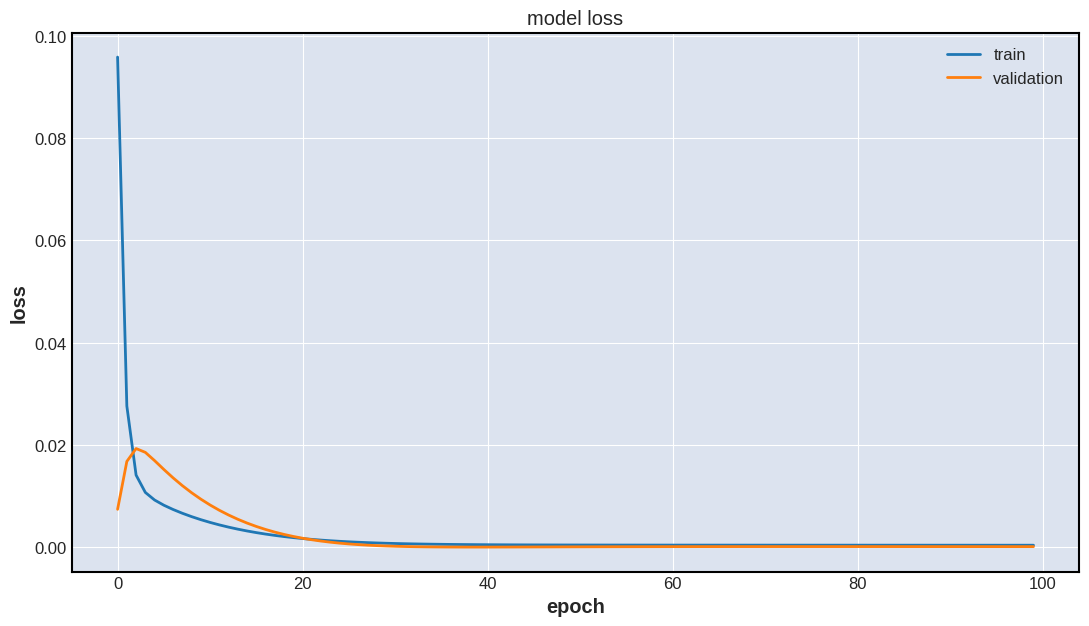

In [126]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

19/19 [==============================] - 0s 3ms/step


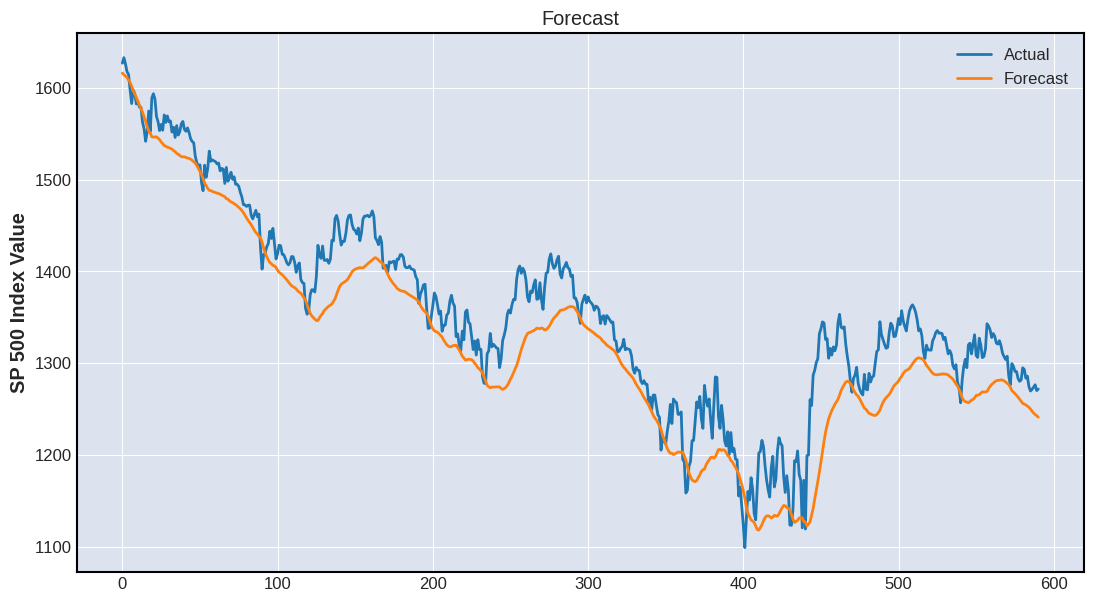

In [127]:
Xt = model1.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt))
plt.title('Forecast')
plt.ylabel('SP 500 Index Value')
# plt.xlabel('epoch')
plt.legend(['Actual', 'Forecast'], loc='upper right')
plt.show()

In [128]:
actual = []
predicted = []
for i in range(X_test.shape[0]):
  Xt = model1.predict(X_test[i].reshape(1, 60,1))
  print('predicted:{}, actual:{}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  predicted.append(scaler.inverse_transform(Xt))
  actual.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

1/1 [==============================] - 0s 313ms/step
predicted:[[1615.8622]], actual:[[1626.67]]
1/1 [==============================] - 0s 16ms/step
predicted:[[1614.0647]], actual:[[1632.69]]
1/1 [==============================] - 0s 17ms/step
predicted:[[1612.7681]], actual:[[1625.96]]
1/1 [==============================] - 0s 16ms/step
predicted:[[1610.9302]], actual:[[1617.5]]
1/1 [==============================] - 0s 17ms/step
predicted:[[1608.4341]], actual:[[1614.42]]
1/1 [==============================] - 0s 17ms/step
predicted:[[1605.7646]], actual:[[1597.59]]
1/1 [==============================] - 0s 17ms/step
predicted:[[1601.7849]], actual:[[1582.7]]
1/1 [==============================] - 0s 17ms/step
predicted:[[1596.695]], actual:[[1597.57]]
1/1 [==============================] - 0s 17ms/step
predicted:[[1593.0746]], actual:[[1593.61]]
1/1 [==============================] - 0s 16ms/step
predicted:[[1589.3783]], actual:[[1582.24]]
1/1 [==============================] - 0s 

In [129]:
result_df = pd.DataFrame({'predicted':list(np.reshape(predicted, (-1))),'actual':list(np.reshape(actual, (-1)))})
result_df.head()

,predicted,actual
0,1615.862183,1626.67
1,1614.064697,1632.69
2,1612.768066,1625.96
3,1610.930176,1617.50
4,1608.434082,1614.42


In [130]:
result_df.shape

(591, 2)

In [131]:
test = result_df['actual']
forecast = result_df['predicted']

In [132]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [133]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Long Short-Term Memory model Mean Square Error :', mean_squared_error(test, forecast))
print('Long Short-Term Memory model Mean Absolute Error :', mean_absolute_error(test, forecast))
print('Long Short-Term Memory model Mean Absolute Percentage Error :', mean_absolute_percentage_error(test, forecast))

Long Short-Term Memory model Mean Square Error : 1982.2838967954685
Long Short-Term Memory model Mean Absolute Error : 36.4408887875423
Long Short-Term Memory model Mean Absolute Percentage Error : 2.7189567497765172


# Stacked Long Short-Term Memory</br>

In [134]:
from keras.layers.attention.multi_head_attention import activation
#Build the model
model2 = Sequential()
model2.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(64))
model2.add(Dense(1))
model2.compile(optimizer='adagrad',loss='mse',metrics='accuracy')

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_2 (LSTM)               (None, 60, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 60, 64)            33024     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [135]:
history2 = model2.fit(X_train,y_train,epochs=100, validation_data=(X_test,y_test), shuffle=False)

Epoch 1/100
74/74 [==============================] - 7s 32ms/step - loss: 0.1064 - accuracy: 0.0000e+00 - val_loss: 0.0238 - val_accuracy: 0.0017
Epoch 2/100
74/74 [==============================] - 1s 14ms/step - loss: 0.0346 - accuracy: 0.0000e+00 - val_loss: 0.0371 - val_accuracy: 0.0017
Epoch 3/100
74/74 [==============================] - 1s 14ms/step - loss: 0.0239 - accuracy: 4.2319e-04 - val_loss: 0.0358 - val_accuracy: 0.0017
Epoch 4/100
74/74 [==============================] - 1s 14ms/step - loss: 0.0205 - accuracy: 4.2319e-04 - val_loss: 0.0319 - val_accuracy: 0.0017
Epoch 5/100
74/74 [==============================] - 1s 14ms/step - loss: 0.0180 - accuracy: 4.2319e-04 - val_loss: 0.0278 - val_accuracy: 0.0017
Epoch 6/100
74/74 [==============================] - 1s 14ms/step - loss: 0.0158 - accuracy: 4.2319e-04 - val_loss: 0.0236 - val_accuracy: 0.0017
Epoch 7/100
74/74 [==============================] - 1s 14ms/step - loss: 0.0137 - accuracy: 4.2319e-04 - val_loss: 0.0197 -

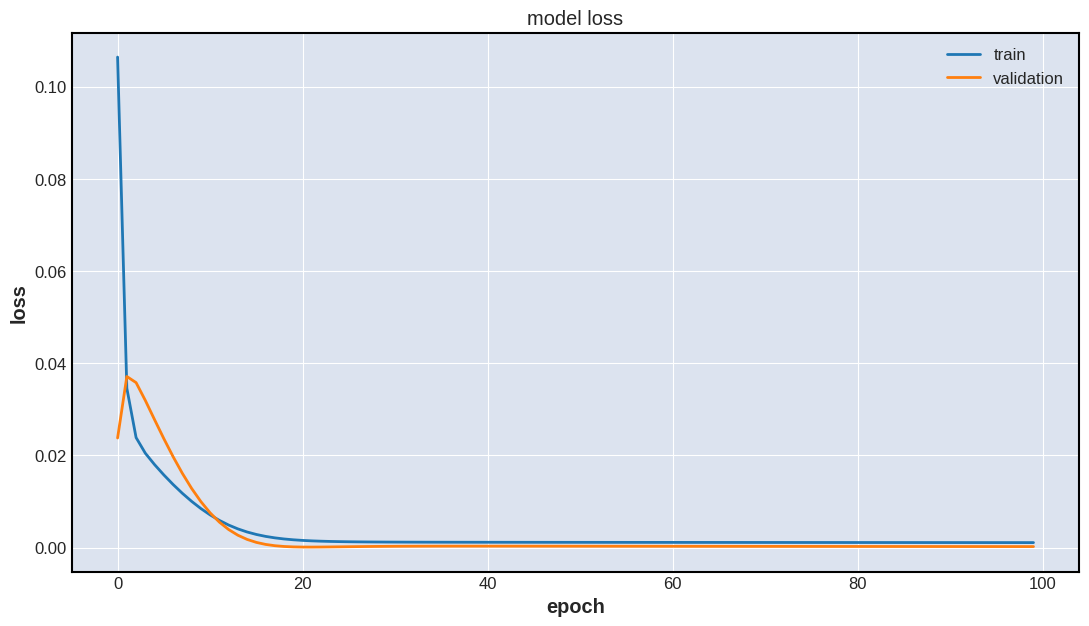

In [136]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

19/19 [==============================] - 1s 7ms/step


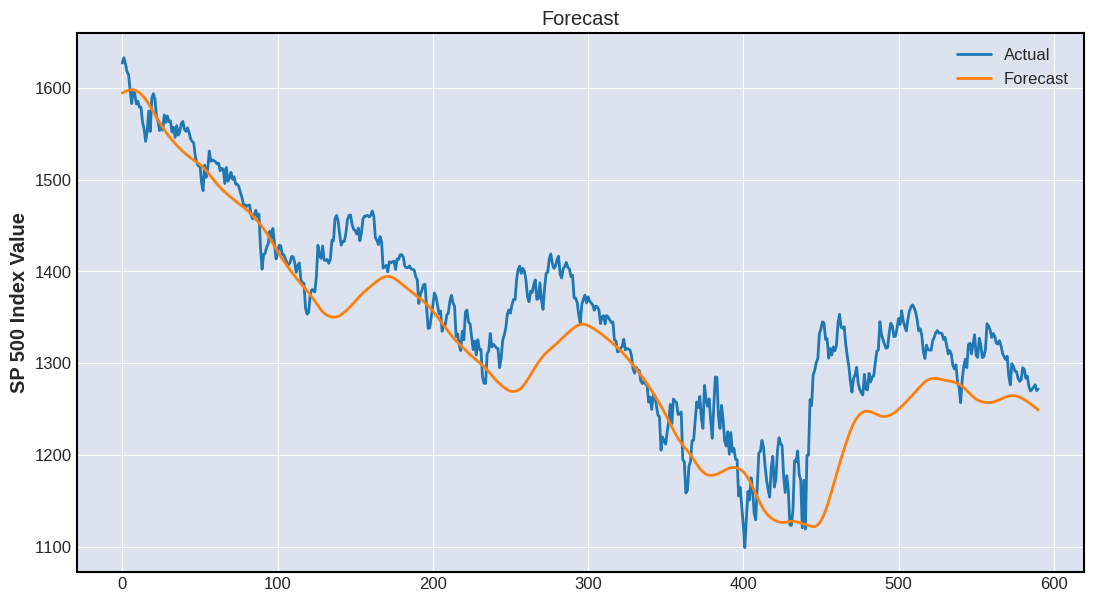

In [137]:
Xt2 = model2.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt2))
plt.title('Forecast')
plt.ylabel('SP 500 Index Value')
# plt.xlabel('epoch')
plt.legend(['Actual', 'Forecast'], loc='upper right')
plt.show()

In [138]:
actual2 = []
predicted2 = []
for i in range(X_test.shape[0]):
  Xt2 = model2.predict(X_test[i].reshape(1, 60,1))
  print('predicted:{}, actual:{}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  predicted2.append(scaler.inverse_transform(Xt2))
  actual2.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

1/1 [==============================] - 1s 1s/step
predicted:[[1241.2544]], actual:[[1626.67]]
1/1 [==============================] - 0s 23ms/step
predicted:[[1241.2544]], actual:[[1632.69]]
1/1 [==============================] - 0s 22ms/step
predicted:[[1241.2544]], actual:[[1625.96]]
1/1 [==============================] - 0s 21ms/step
predicted:[[1241.2544]], actual:[[1617.5]]
1/1 [==============================] - 0s 22ms/step
predicted:[[1241.2544]], actual:[[1614.42]]
1/1 [==============================] - 0s 25ms/step
predicted:[[1241.2544]], actual:[[1597.59]]
1/1 [==============================] - 0s 22ms/step
predicted:[[1241.2544]], actual:[[1582.7]]
1/1 [==============================] - 0s 23ms/step
predicted:[[1241.2544]], actual:[[1597.57]]
1/1 [==============================] - 0s 24ms/step
predicted:[[1241.2544]], actual:[[1593.61]]
1/1 [==============================] - 0s 25ms/step
predicted:[[1241.2544]], actual:[[1582.24]]
1/1 [==============================] - 0s 25

In [139]:
result_df2 = pd.DataFrame({'predicted':list(np.reshape(predicted2, (-1))),'actual':list(np.reshape(actual2, (-1)))})
result_df2.head()

,predicted,actual
0,1594.119629,1626.67
1,1595.065430,1632.69
2,1595.904663,1625.96
3,1596.613892,1617.50
4,1597.177979,1614.42


In [140]:
test2 = result_df2['actual']
forecast2 = result_df2['predicted']

In [141]:
print('Long Short-Term Memory model Mean Square Error :', mean_squared_error(test2, forecast2))
print('Long Short-Term Memory model Mean Absolute Error :', mean_absolute_error(test2, forecast2))
print('Long Short-Term Memory model Mean Absolute Percentage Error :', mean_absolute_percentage_error(test2, forecast2))

Long Short-Term Memory model Mean Square Error : 3391.124919071473
Long Short-Term Memory model Mean Absolute Error : 43.312314031765546
Long Short-Term Memory model Mean Absolute Percentage Error : 3.233124420228348


# Convolution Neural Networks Long Short-Term Memory</br>

In [142]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import BatchNormalization

In [143]:
X_train = X_train.reshape((X_train.shape[0],1, 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

(2363, 1, 1, 60) (591, 1, 1, 60)


In [144]:
model3 = Sequential()
# model3.add(BatchNormalization())
model3.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 60)))
# model3.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 60)))
model3.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model3.add(TimeDistributed(Flatten()))
# model3.add(BatchNormalization())
model3.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
# model3.add(LSTM(64, return_sequences=True))
# model3.add(Long Short-Term Memory(64, return_sequences=True))
model3.add(LSTM(64))
# model3.add(BatchNormalization())
# model3.add(Dropout(0.2, input_shape=(60,)))

model3.add(Dense(1, activation = 'relu'))
# model3.add(Dense(1, activation = 'softmax'))

model3.compile(optimizer='adagrad', loss='mse',metrics='accuracy')

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 1, 64)      3904      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_5 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                      

In [145]:
history3 = model3.fit(X_train,y_train,epochs=100, validation_data=(X_test,y_test), shuffle=False)

Epoch 1/100
74/74 [==============================] - 8s 16ms/step - loss: 0.2540 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0017
Epoch 2/100
74/74 [==============================] - 0s 5ms/step - loss: 0.2503 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0017
Epoch 3/100
74/74 [==============================] - 0s 6ms/step - loss: 0.2216 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0017
Epoch 4/100
74/74 [==============================] - 0s 5ms/step - loss: 0.1969 - accuracy: 0.0000e+00 - val_loss: 8.0165e-04 - val_accuracy: 0.0017
Epoch 5/100
74/74 [==============================] - 0s 6ms/step - loss: 0.1770 - accuracy: 0.0000e+00 - val_loss: 8.1787e-04 - val_accuracy: 0.0017
Epoch 6/100
74/74 [==============================] - 0s 6ms/step - loss: 0.1598 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0017
Epoch 7/100
74/74 [==============================] - 0s 6ms/step - loss: 0.1443 - accuracy: 0.0000e+00 - val_loss: 0.0019

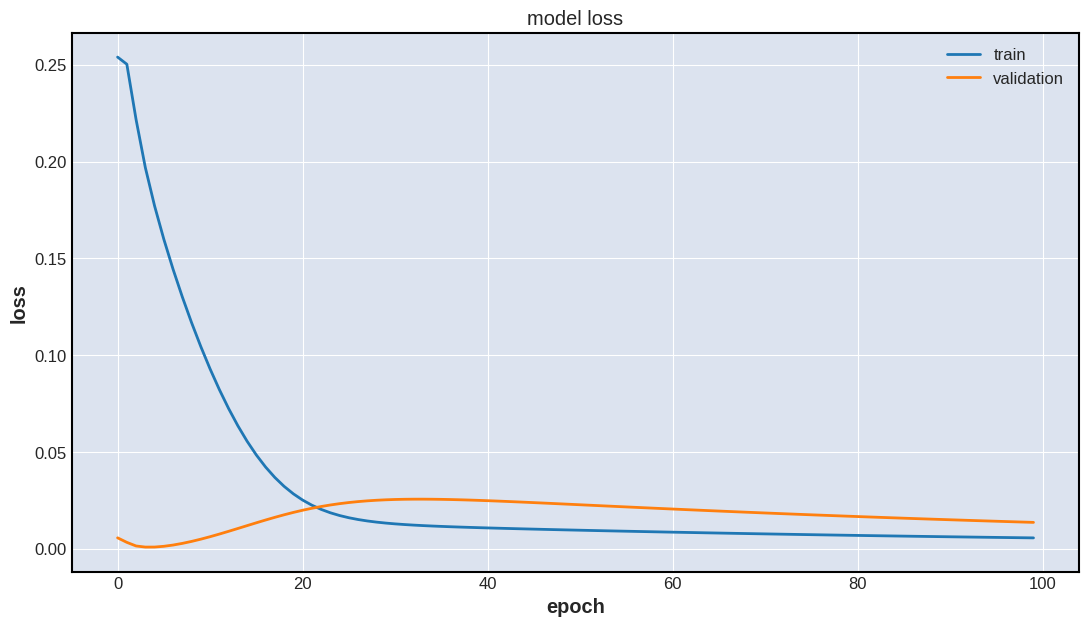

In [146]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

19/19 [==============================] - 1s 2ms/step


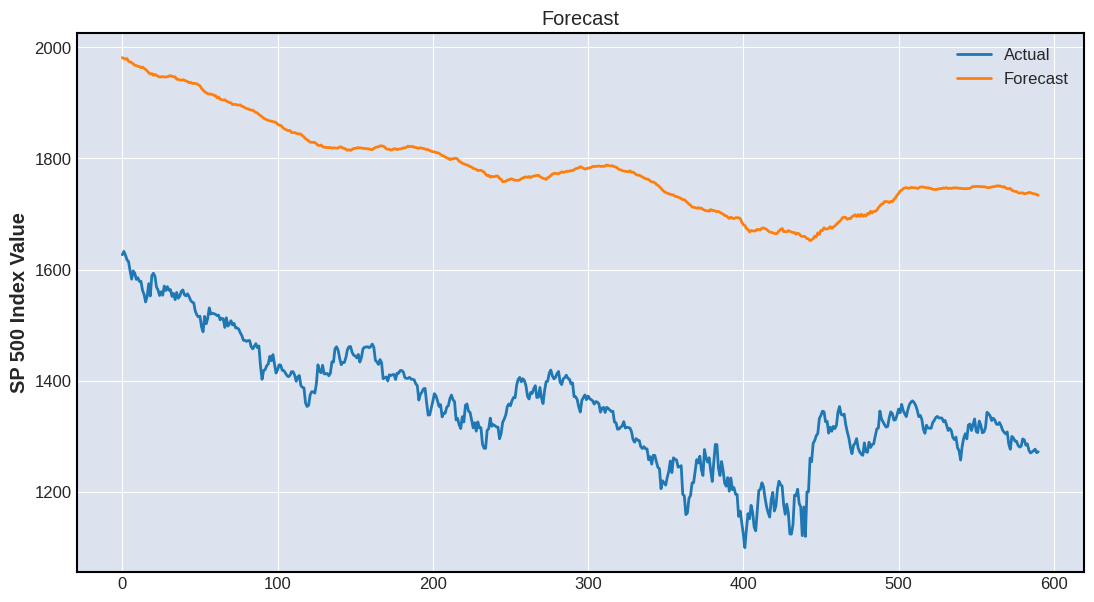

In [147]:
Xt3 = model3.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt3))
plt.title('Forecast')
plt.ylabel('SP 500 Index Value')
# plt.xlabel('epoch')
plt.legend(['Actual', 'Forecast'], loc='upper right')
plt.show()

In [148]:
actual3 = []
predicted3 = []
for i in range(X_test.shape[0]):
  Xt3 = model3.predict(X_test[i].reshape(1, 1, 1, 60))
  print('predicted:{}, actual:{}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  predicted3.append(scaler.inverse_transform(Xt3))
  actual3.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

1/1 [==============================] - 0s 28ms/step
predicted:[[1241.2544]], actual:[[1626.67]]
1/1 [==============================] - 0s 15ms/step
predicted:[[1241.2544]], actual:[[1632.69]]
1/1 [==============================] - 0s 14ms/step
predicted:[[1241.2544]], actual:[[1625.96]]
1/1 [==============================] - 0s 15ms/step
predicted:[[1241.2544]], actual:[[1617.5]]
1/1 [==============================] - 0s 15ms/step
predicted:[[1241.2544]], actual:[[1614.42]]
1/1 [==============================] - 0s 15ms/step
predicted:[[1241.2544]], actual:[[1597.59]]
1/1 [==============================] - 0s 15ms/step
predicted:[[1241.2544]], actual:[[1582.7]]
1/1 [==============================] - 0s 16ms/step
predicted:[[1241.2544]], actual:[[1597.57]]
1/1 [==============================] - 0s 14ms/step
predicted:[[1241.2544]], actual:[[1593.61]]
1/1 [==============================] - 0s 17ms/step
predicted:[[1241.2544]], actual:[[1582.24]]
1/1 [==============================] - 0s 

In [149]:
result_df3 = pd.DataFrame({'predicted':list(np.reshape(predicted3, (-1))),'actual':list(np.reshape(actual3, (-1)))})
result_df3.head(10)

,predicted,actual
0,1981.547241,1626.67
1,1980.252075,1632.69
2,1978.781494,1625.96
3,1979.866577,1617.50
4,1975.032471,1614.42
5,1974.015137,1597.59
6,1972.382324,1582.70
7,1970.462646,1597.57
8,1967.789673,1593.61
9,1967.243652,1582.24


In [150]:
test3 = result_df3['actual']
forecast3 = result_df3['predicted']

In [151]:
print('CNN Long Short-Term Memory model Mean Square Error :', mean_squared_error(test3, forecast3))
print('CNN Long Short-Term Memory model Mean Absolute Error :', mean_absolute_error(test3, forecast3))
print('CNN Long Short-Term Memory model Mean Absolute Percentage Error :', mean_absolute_percentage_error(test3, forecast3))

CNN Long Short-Term Memory model Mean Square Error : 185402.47606903355
CNN Long Short-Term Memory model Mean Absolute Error : 428.14277112415397
CNN Long Short-Term Memory model Mean Absolute Percentage Error : 31.98198741918297


#Stacked CNN-LSTM with BN and Dropout

In [153]:
model4 = Sequential()
# model4.add(BatchNormalization())
model4.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 60)))
model4.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 60)))
model4.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model4.add(TimeDistributed(Flatten()))
model4.add(BatchNormalization())
model4.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model4.add(LSTM(64, return_sequences=True))
model4.add(LSTM(64, return_sequences=True))
model4.add(LSTM(64))
model4.add(BatchNormalization())
model4.add(Dropout(0.2, input_shape=(60,)))

model4.add(Dense(1, activation = 'relu'))
model4.add(Dense(1, activation = 'softmax'))

model4.compile(optimizer='adagrad', loss='mse',metrics='accuracy')

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 1, 64)      3904      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 1, 64)      4160      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, None, 64)        

In [156]:
history4 = model4.fit(X_train,y_train,epochs=100, validation_data=(X_test,y_test), shuffle=False, batch_size=10)

Epoch 1/100
237/237 [==============================] - 2s 10ms/step - loss: 0.3570 - accuracy: 4.2319e-04 - val_loss: 0.8671 - val_accuracy: 0.0000e+00
Epoch 2/100
237/237 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: 4.2319e-04 - val_loss: 0.8671 - val_accuracy: 0.0000e+00
Epoch 3/100
237/237 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: 4.2319e-04 - val_loss: 0.8671 - val_accuracy: 0.0000e+00
Epoch 4/100
237/237 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: 4.2319e-04 - val_loss: 0.8671 - val_accuracy: 0.0000e+00
Epoch 5/100
237/237 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: 4.2319e-04 - val_loss: 0.8671 - val_accuracy: 0.0000e+00
Epoch 6/100
237/237 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: 4.2319e-04 - val_loss: 0.8671 - val_accuracy: 0.0000e+00
Epoch 7/100
237/237 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: